In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import backtrader as bt
import datetime
%matplotlib inline

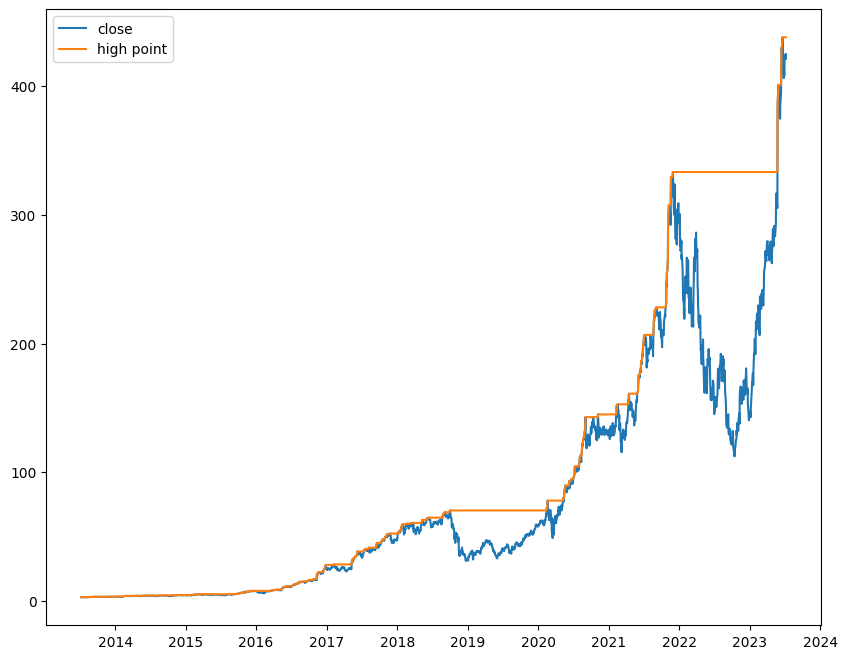

In [2]:
data = pd.read_excel(r'/home/baichen/Downloads/ibtrade/NVDA_10Y_1day.xlsx',index_col=0,parse_dates=["Date"])
data['all_high'] = data['Close'].expanding().max()
plt.figure(figsize=(10,8))
plt.plot(data['Close'],label='close')
plt.plot(data['all_high'],label='high point')
plt.legend(loc="upper left")
plt.show()

In [3]:
data['dd']=data['all_high']/data['Close']-1
data.head(5)

,Open,High,Low,Close,Volume,all_high,dd
Date,,,,,,,
2013-07-10,2.7158,2.7596,2.7120,2.7520,53628,2.7520,0.000000
2013-07-11,2.7711,2.7921,2.7615,2.7901,43072,2.7901,0.000000
2013-07-12,2.7844,2.8188,2.7768,2.7921,53484,2.7921,0.000000
2013-07-15,2.7825,2.7901,2.7425,2.7863,36276,2.7921,0.002082
2013-07-16,2.7978,2.8149,2.7844,2.8016,38060,2.8016,0.000000


In [4]:
#add my own columns to backtrader
class PandasData_Extend(bt.feeds.PandasData):
    lines = ( 'open', 'high', 'low', 'close', 'volume','all_high','dd')
    params = (
        ('datetime', None),
        ('open', 0),
        ('high', 1),
        ('low', 2),
        ('close', 3),
        ('volume',4),
        ('all_high',5),
        ('dd',6)
    )

In [5]:
data_parsed=PandasData_Extend(dataname=data,datetime=None,open=0,high=1,low=2,close=3,volume=4,all_high=5,dd=6,openinterest=-1)

In [6]:
class BuyDipStrategy(bt.Strategy):
    params = (('buy1',0.1),('buy2',0.2),('buy3',0.3))
    
    def __init__(self):
        self.dataclose = self.datas[0].close
        self.dd = self.datas[0].dd
        self.all_high = self.datas[0].all_high

        self.flag2 = False 
        self.falg3 = False

    def next(self):
        
        if self.position.size == 0 and  self.dd[-1]< self.p.buy1 and self.dd[0] > self.p.buy1:
            self.order = self.order_target_percent(target=0.3,data='myData')
            #print(self.datas[0].datetime.date(),"buy1: {} ; dd: {} ; all_high: {}".format(self.dataclose[0],self.dd[0],self.all_high[0]))
            
        elif self.position.size > 0 and self.dd[-1] < self.p.buy2 and self.dd[0] > self.p.buy2 and not self.flag2:
            self.order = self.order_target_percent(target=0.5,data='myData')
            self.flag2 = True
            #print(self.datas[0].datetime.date(),"buy2: {} ; dd: {} ; all_high: {}".format(self.dataclose[0],self.dd[0],self.all_high[0]))
            
        elif self.position.size > 0 and self.dd[-1] < self.p.buy3 and self.dd[0] >self.p.buy3 and not self.flag3:
            self.order = self.order_target_percent(target=0.95,data='myData')
            self.flag3 = True
            #print(self.datas[0].datetime.date(),"buy3: {} ; dd: {} ; all_high: {}".format(self.dataclose[0],self.dd[0],self.all_high[0]))

        if self.position.size > 0 and self.all_high[-1] <= self.dataclose[0]:
            self.order = self.close()
            self.flag2 = False
            self.flag3 = False
            #print(self.datas[0].datetime.date(),"sell: {} ; dd: {} ; all_high: {}".format(self.dataclose[0],self.dd[0],self.all_high[0]))

In [7]:
buyDip = bt.Cerebro()
buyDip.adddata(data_parsed,name='myData')
buyDip.addstrategy(BuyDipStrategy)

0

In [8]:
#buyDip.optstrategy(BuyDipStrategy,buy1=[1/i for i in range(1,10)],buy2=[1/i for i in range(1,10)],buy3=[1/i for i in range(1,10)])

In [9]:
buyDip.addobserver(bt.observers.Value)

In [10]:
buyDip.addanalyzer(bt.analyzers.SharpeRatio)
buyDip.addanalyzer(bt.analyzers.DrawDown)
buyDip.addanalyzer(bt.analyzers.TradeAnalyzer)
buyDip.addanalyzer(bt.analyzers.Transactions)

In [11]:
#use Pyfolio 
buyDip.addanalyzer(bt.analyzers.PyFolio)

res=buyDip.run()[0]
pyfolio= res.analyzers.getbyname('pyfolio')
returns,positions,transactions,gross_lev = pyfolio.get_pf_items()

returns.to_hdf('return.h5',key='data')
positions.to_hdf('position.h5',key='data')
transactions.to_hdf('transactions.h5',key='data')

<Axes: xlabel='index'>

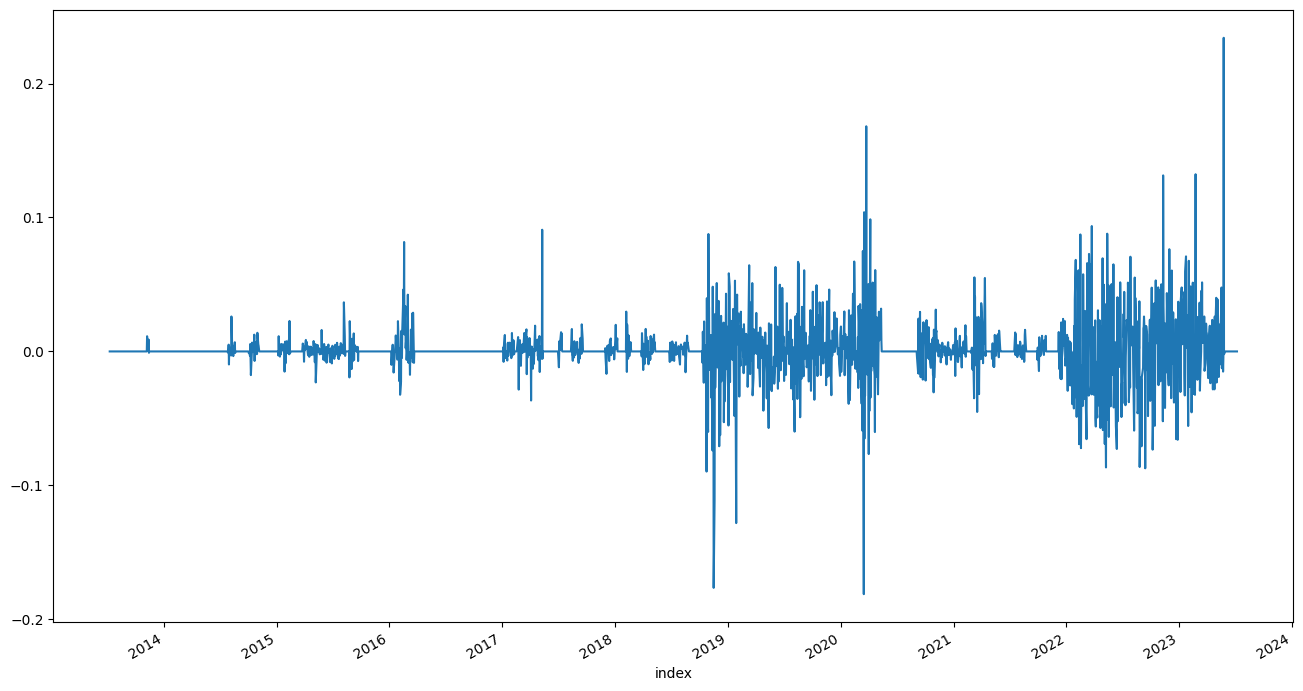

In [12]:
%matplotlib inline
return_df = pd.read_hdf('return.h5')
return_df.plot(figsize=(16,9))

<Axes: ylabel='Frequency'>

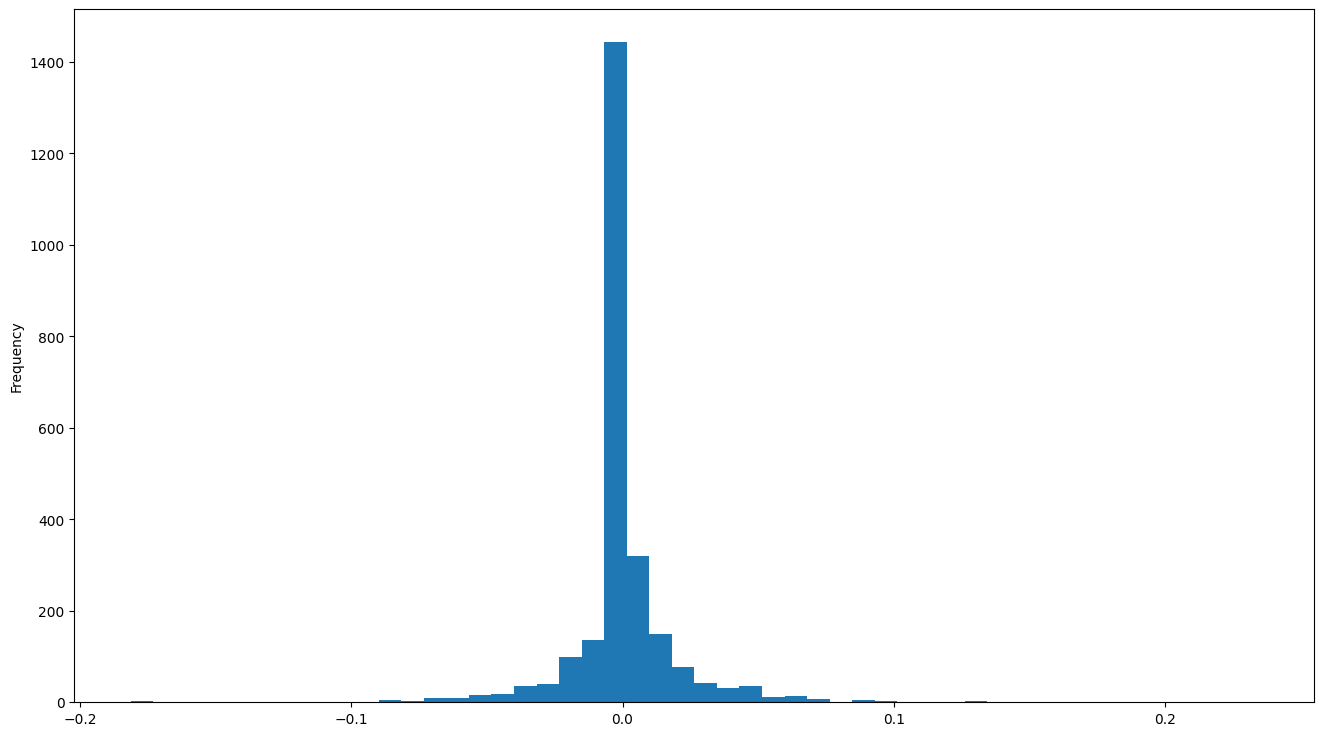

In [13]:
return_df.plot.hist(bins=50,figsize=(16,9))

In [14]:
return_df.describe()

count    2516.000000
mean        0.001006
std         0.019707
min        -0.181227
25%        -0.000414
50%         0.000000
75%         0.002989
max         0.234178
Name: return, dtype: float64

In [15]:
res.analyzers.sharperatio.get_analysis()

OrderedDict([('sharperatio', 0.5723265459202463)])

In [16]:
res.analyzers.drawdown.get_analysis()

AutoOrderedDict([('len', 28),
                 ('drawdown', 0.2065162926965906),
                 ('moneydown', 159.5503000000026),
                 ('max',
                  AutoOrderedDict([('len', 296),
                                   ('drawdown', 58.2748685253403),
                                   ('moneydown', 34288.2834)]))])

In [17]:
res.analyzers.tradeanalyzer.get_analysis()

AutoOrderedDict([('total',
                  AutoOrderedDict([('total', 24),
                                   ('open', 0),
                                   ('closed', 24)])),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 24),
                                                     ('longest', 24)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 0)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      67098.42190000002),
                                                     ('average',
                                                      2795.7675791666675)])),
                                   ('net',
                          

In [18]:
res.analyzers.transactions.get_analysis()

OrderedDict([(datetime.datetime(2013, 11, 8, 0, 0),
              [[1059, 2.9212, 0, 'myData', -3093.5508]]),
             (datetime.datetime(2013, 11, 14, 0, 0),
              [[-1059, 3.1334, 0, 'myData', 3318.2706]]),
             (datetime.datetime(2014, 7, 28, 0, 0),
              [[835, 3.6665, 0, 'myData', -3061.5275]]),
             (datetime.datetime(2014, 8, 20, 0, 0),
              [[-835, 4.0536, 0, 'myData', 3384.7560000000003]]),
             (datetime.datetime(2014, 10, 3, 0, 0),
              [[828, 3.8436, 0, 'myData', -3182.5008]]),
             (datetime.datetime(2014, 11, 5, 0, 0),
              [[-828, 4.2531, 0, 'myData', 3521.5668]]),
             (datetime.datetime(2015, 1, 7, 0, 0),
              [[796, 4.1295, 0, 'myData', -3287.0820000000003]]),
             (datetime.datetime(2015, 2, 13, 0, 0),
              [[-796, 4.7426, 0, 'myData', 3775.1096000000002]]),
             (datetime.datetime(2015, 3, 26, 0, 0),
              [[747, 4.4954, 0, 'myData', -3358

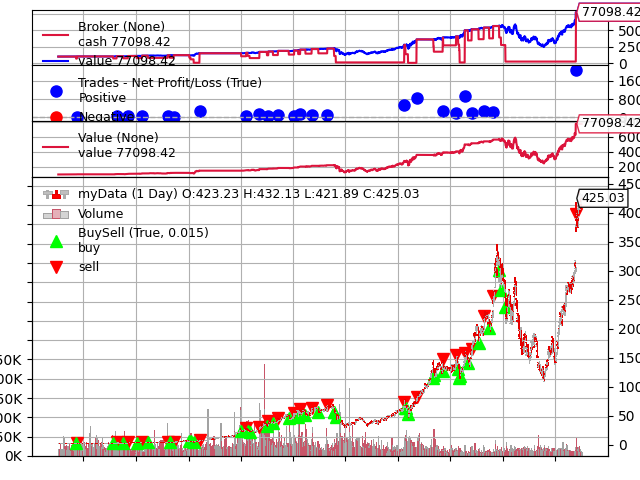

[[<Figure size 640x480 with 5 Axes>]]

In [23]:
#%matplotlib inline
%matplotlib widget

buyDip.plot(iplot=False,style='candle',width=80)
